In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/banana1/dataset/unripe/ur(357).jpg
/kaggle/input/banana1/dataset/unripe/ur(694).jpg
/kaggle/input/banana1/dataset/unripe/ur(278).jpg
/kaggle/input/banana1/dataset/unripe/ur(1340).jpg
/kaggle/input/banana1/dataset/unripe/ur(409).jpg
/kaggle/input/banana1/dataset/unripe/ur(608).jpg
/kaggle/input/banana1/dataset/unripe/ur(773).jpg
/kaggle/input/banana1/dataset/unripe/ur(515).jpg
/kaggle/input/banana1/dataset/unripe/ur(837).jpg
/kaggle/input/banana1/dataset/unripe/ur(1003).jpg
/kaggle/input/banana1/dataset/unripe/ur(1069).jpg
/kaggle/input/banana1/dataset/unripe/ur(869).jpg
/kaggle/input/banana1/dataset/unripe/ur(543).jpg
/kaggle/input/banana1/dataset/unripe/ur(1483).jpg
/kaggle/input/banana1/dataset/unripe/ur(1358).jpg
/kaggle/input/banana1/dataset/unripe/ur(314).jpg
/kaggle/input/banana1/dataset/unripe/ur(716).jpg
/kaggle/input/banana1/dataset/unripe/ur(1454).jpg
/kaggle/input/banana1/dataset/unripe/ur(5).jpg
/kaggle/input/banana1/dataset/unripe/ur(449).jpg
/kaggle/input/ba

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


2024-03-16 22:06:03.409195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 22:06:03.409328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 22:06:03.528117: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set the dataset path
dataset_path = "/kaggle/input/banana1/dataset"

In [4]:
import os
import cv2
import numpy as np

def load_images(dataset_path):
    images = []
    labels = []
    for folder in os.listdir(dataset_path):
        label = folder
        for file in os.listdir(os.path.join(dataset_path, folder)):
            image_path = os.path.join(dataset_path, folder, file)
            
            # Load image
            image = cv2.imread(image_path)
            
            if image is None:
                print(f"Error: Unable to load image '{image_path}'")
                continue
            
            # Preprocess image (normalize, resize, and sharpen)
            normalized_image = image / 255.0
            resized_image = cv2.resize(normalized_image, (229, 229))
            sharpened_image = sharpen_image(resized_image)
            
            images.append(sharpened_image)
            labels.append(label)
    return np.array(images), np.array(labels)

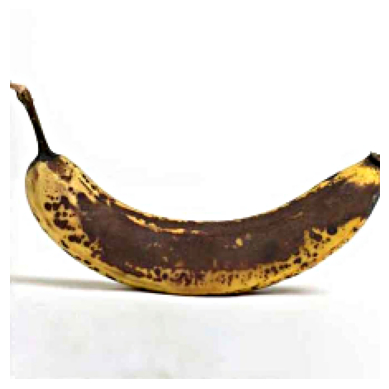

In [5]:
import cv2
import matplotlib.pyplot as plt

def preprocess_and_show_image(image_path):
    # Read image
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Error: Unable to load image '{image_path}'")
        return
    
    # Preprocess image (resize and sharpen)
    resized_image = cv2.resize(image, (224, 224))
    sharpened_image = sharpen_image(resized_image)
    
    # Display preprocessed image
    plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
    plt.axis('off')
    plt.show()

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# Example usage:
image_path = "/kaggle/input/banana1/dataset/overripe/OR(1).jpg"  # Replace with the path to your image
preprocess_and_show_image(image_path)


In [6]:
# Load images and labels
images, labels = load_images(dataset_path)

In [7]:
# Preprocessing 1: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [8]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=3)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=3)

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


# Define the number of classes
num_classes = 3

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False)

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

    
    
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),  # Adjusted learning rate
              metrics=['accuracy'])

model.summary()

/tmp/ipykernel_4093/2761297639.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        512 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │          0 │ block_1_depthwis… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, None,      │      2,304 │ block_1_depthwis

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_mobilenet_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Prepare the data augmentation generator for training
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=16)

# Then, when training the model, use the generator
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=(X_test, y_test_one_hot),  # Make sure your validation data is properly processed
    verbose=2,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1710627055.012012    4151 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710627055.043869    4151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710627096.415822    4151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710627101.081622    4151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 - 60s - 265ms/step - accuracy: 0.8864 - loss: 0.3444 - val_accuracy: 0.9500 - val_loss: 0.1651 - learning_rate: 1.0000e-04
Epoch 2/25
225/225 - 35s - 157ms/step - accuracy: 0.9564 - loss: 0.1455 - val_accuracy: 0.9578 - val_loss: 0.1271 - learning_rate: 1.0000e-04
Epoch 3/25
225/225 - 35s - 157ms/step - accuracy: 0.9653 - loss: 0.1105 - val_accuracy: 0.9633 - val_loss: 0.1052 - learning_rate: 1.0000e-04
Epoch 4/25
225/225 - 36s - 158ms/step - accuracy: 0.9686 - loss: 0.0921 - val_accuracy: 0.9667 - val_loss: 0.0956 - learning_rate: 1.0000e-04
Epoch 5/25
225/225 - 35s - 155ms/step - accuracy: 0.9722 - loss: 0.0857 - val_accuracy: 0.9467 - val_loss: 0.1289 - learning_rate: 1.0000e-04
Epoch 6/25
225/225 - 35s - 155ms/step - accuracy: 0.9739 - loss: 0.0758 - val_accuracy: 0.9656 - val_loss: 0.0962 - learning_rate: 1.0000e-04
Epoch 7/25
225/225 - 36s - 158ms/step - accuracy: 0.9725 - loss: 0.0749 - val_accuracy: 0.9689 - val_loss: 0.0929 - learning_rate: 1.0000e-04
Epoch 8/25
225/22

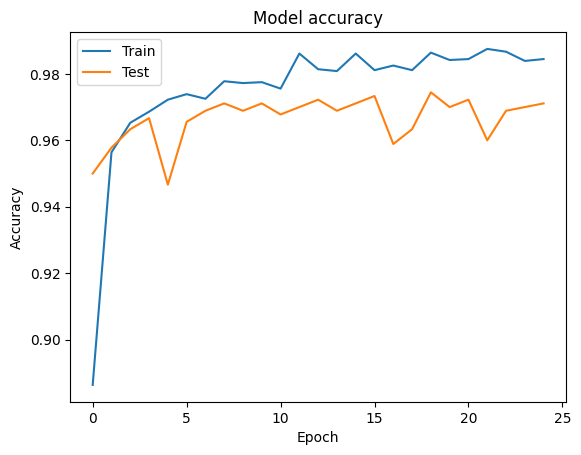

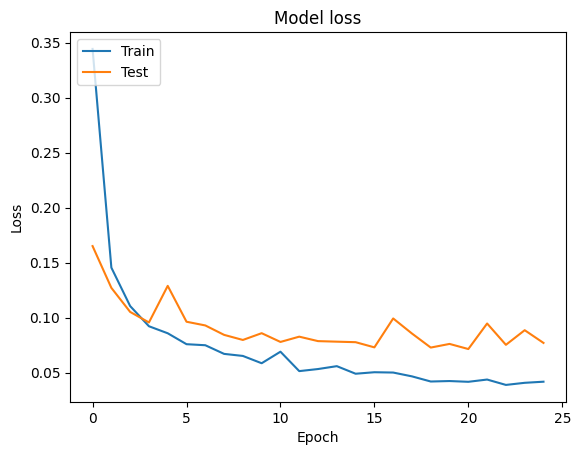

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [13]:
model.evaluate(X_train, y_train_one_hot)

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9904 - loss: 0.0303


W0000 00:00:1710627954.625384    4151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.031213361769914627, 0.9894444346427917]

In [14]:
model.evaluate(X_test, y_test_one_hot)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9795 - loss: 0.0555


[0.07141008228063583, 0.9722222089767456]

In [15]:
y_pred =model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_pred

 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

W0000 00:00:1710627960.105871    4151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step


W0000 00:00:1710627963.837010    4151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([0, 1, 0, 0, 2, 0, 0, 2, 1, 1, 2, 0, 1, 2, 2, 1, 2, 1, 0, 0, 0, 0,
       1, 1, 1, 2, 0, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 1,
       2, 0, 0, 1, 2, 2, 1, 1, 0, 1, 1, 2, 2, 2, 0, 2, 1, 1, 2, 0, 2, 1,
       2, 2, 1, 2, 1, 1, 0, 2, 0, 2, 1, 2, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0,
       2, 1, 2, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 2, 1,
       1, 0, 2, 0, 0, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 2,
       2, 1, 0, 1, 2, 0, 2, 1, 1, 0, 1, 2, 2, 0, 1, 0, 2, 1, 1, 2, 2, 1,
       2, 0, 0, 2, 2, 0, 2, 0, 2, 1, 0, 1, 1, 2, 2, 1, 1, 0, 2, 1, 2, 2,
       1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 1, 1, 1, 0,
       1, 2, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, 2, 2, 1, 2, 0, 2, 0, 2, 0, 0,
       1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 0, 0,
       0, 1, 1, 2, 1, 1, 0, 0, 2, 0, 1, 0, 2, 1, 1, 1, 1, 2, 0, 2, 2, 2,
       0, 0, 2, 1, 1, 0, 0, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 1, 2, 0, 0, 1,
       0, 0, 2, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 0, 2,

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       295
           1       0.96      0.96      0.96       293
           2       0.99      0.99      0.99       312

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



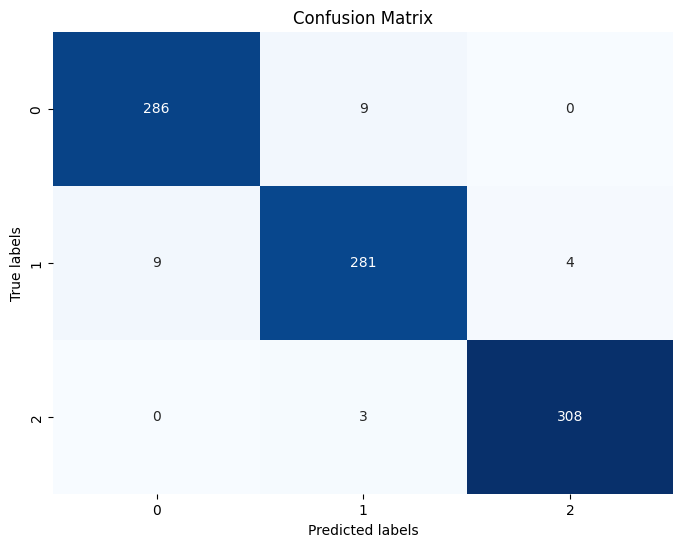

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_val = np.argmax(y_test_one_hot, axis = 1)
print(classification_report(y_pred, y_test_encoded))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

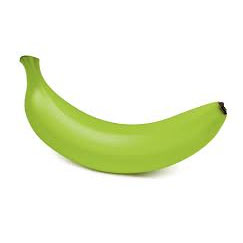

In [17]:

from IPython.display import Image, display
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import matplotlib.cm as cm 

img_size = (224,224)
last_conv_layer_name = " Conv_1"

# The local path to our target image
img_path = '/kaggle/input/banana1/dataset/unripe/ur(1).jpg'
display(Image(img_path))

In [18]:
# The Grad-CAM algorithm
def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img)
    array = tf.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap




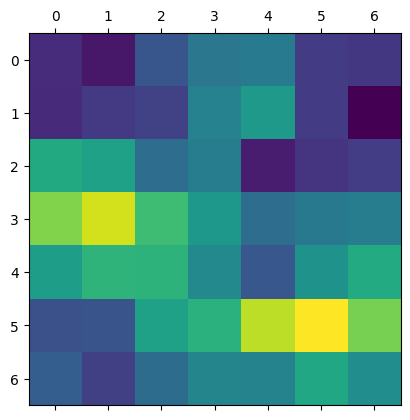

In [19]:
# Load the image
img_array = get_img_array(img_path, size=img_size)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, "Conv_1")

# Display heatmap
plt.matshow(heatmap)
plt.show()


/tmp/ipykernel_4093/3578694723.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")  # Change c_map to cm


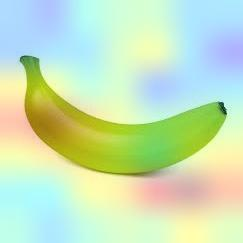

In [20]:
# Function to save and display Grad-CAM
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")  # Change c_map to cm

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]

    # Create an image with RGB colorized heatmap
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad-CAM
    display(Image(cam_path))

# Save and display Grad-CAM
save_and_display_gradcam(img_path, heatmap)